In [2]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.utils import make_grid

In [2]:
MODEL_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\model_test\c_unet_1647162803.6921902.pth"
RED_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95red_filter\\"
GREEN_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95green_filter\\"
BLUE_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95blue_filter\\"
NIR_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95nir_filter\\"
GT_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95gt_filter\\"

r_dir = Path(RED_PATH)

Percentage of cloud

In [3]:
#   0%      1 - 30%    30 - 70%    70 - 100%
no_cloud, less_cloud, more_cloud, full_cloud = [], [], [], []

low_threshold = 384*384 * 0.3
high_threshold = 384*384 * 0.7

for file in os.listdir(GT_PATH):
    img = cv2.imread(GT_PATH + file)
    
    occurrences = np.count_nonzero(img[:, :, 0] == 255)

    if occurrences == 0:
        no_cloud.append(file)
        continue
    elif occurrences < low_threshold:
        less_cloud.append(file)
        continue
    elif occurrences < high_threshold:
        more_cloud.append(file)
    else:
        full_cloud.append(file)

print("No cloud images:\t", len(no_cloud))
print("Less cloud images:\t", len(less_cloud))
print("More cloud images:\t", len(more_cloud))
print("Full cloud images:\t", len(full_cloud))
print("Total images:\t\t", len(os.listdir(GT_PATH)))

No cloud images:	 4089
Less cloud images:	 3946
More cloud images:	 2315
Full cloud images:	 5997
Total images:		 16347


In [5]:
def to_path(list):
    for i in range(len(list)):
        list[i] = RED_PATH + list[i].replace("gt", "red")
    return list

In [6]:
no_cloud_list = to_path(no_cloud)
less_cloud_list = to_path(less_cloud)
more_cloud_list = to_path(more_cloud)
full_cloud_list = to_path(full_cloud)

In [ ]:
print(no_cloud_list[:5])

In [7]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, file_list):
        super().__init__()
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in file_list if not os.path.isdir(f)]
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        files = {
            'red': r_file, 
            'green': r_file.replace('red', 'green'),
            'blue': r_file.replace('red', 'blue'), 
            'nir': r_file.replace('red', 'nir'),
            'gt': r_file.replace('red', 'gt')
        }
        return files
                                       
    def __len__(self):
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([
            np.array(Image.open(self.files[idx]['red'])),
            np.array(Image.open(self.files[idx]['green'])),
            np.array(Image.open(self.files[idx]['blue'])),
        ], axis=2)
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max) # normalized


    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=True, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.long)
        return x, y
    
    def __repr__(self):
        return f'Dataset class with {self.__len__()} files'

In [8]:
no_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, no_cloud_list)
less_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, less_cloud_list)
more_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, more_cloud_list)
full_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, full_cloud_list)

print(no_cloud_data)
print(less_cloud_data)
print(more_cloud_data)
print(full_cloud_data)

Dataset class with 4089 files
Dataset class with 3946 files
Dataset class with 2315 files
Dataset class with 5997 files


In [9]:
# Single input example
x, y = no_cloud_data[0]
print(f'Image: {x.shape}')
print(f'Mask: {y.shape}')

Image: torch.Size([4, 384, 384])
Mask: torch.Size([384, 384])


In [10]:
class depthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [11]:
class C_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = self.contract_block(in_channels, 32)
        self.conv2 = self.contract_block(32, 64)
        self.conv3 = self.contract_block(64, 128)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64, 32, 3, 1)
        self.upconv1 = self.expand_block(32, out_channels, 3, 1)

        self.out = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 1),
            nn.Sigmoid()
        )


    def __call__(self, x):
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(upconv3)
        upconv1 = self.upconv1(upconv2)

        out = self.out(upconv1)

        return out


    def contract_block(self, in_channels, out_channels):
        contract = nn.Sequential(
            depthwiseSeparableConv(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        return contract


    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )
        return expand

In [13]:
def my_collate(batch):
    batch = list(filter (lambda x:torch.sum(x[0]).item() != 0, batch))
    if len(batch) == 0:
        print("DOOOOO")
    return torch.utils.data.dataloader.default_collate(batch)

# Constants
BATCH_SIZE = 32
NUM_WORKER = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device.")

no_cloud_loader = DataLoader(no_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
less_cloud_loader = DataLoader(less_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
more_cloud_loader = DataLoader(more_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
full_cloud_loader = DataLoader(full_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)

Using cpu device.


In [ ]:
# View batch
for images, labels in no_cloud_loader:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
    break

In [14]:
c_unet = C_UNet(4, 2)
c_unet.to(DEVICE)

c_unet.load_state_dict(torch.load(MODEL_PATH))
c_unet.eval()

C_UNet(
  (conv1): Sequential(
    (0): depthwiseSeparableConv(
      (depthwise): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4)
      (pointwise): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): depthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): depthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [15]:
criterion = torch.nn.CrossEntropyLoss()

def accuracy(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean().item()

def get_accuracy(data_loader, model):
    lost, acc = [], []

    for images, targets in tqdm(data_loader):
        with torch.no_grad():
            # Send to device
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            # Loss
            predictions = model(images)
            loss = criterion(predictions, targets)
            lost.append(loss.item())
            
            # Accuracy
            acc.append(accuracy(predictions, targets))

    return np.mean(lost), np.mean(acc)

In [ ]:
no_cloud_lost, no_cloud_acc = get_accuracy(no_cloud_loader, c_unet)
less_cloud_lost, less_cloud_acc = get_accuracy(less_cloud_loader, c_unet)
more_cloud_lost, more_cloud_acc = get_accuracy(more_cloud_loader, c_unet)
full_cloud_lost, full_cloud_acc = get_accuracy(full_cloud_loader, c_unet)

In [ ]:
print("No cloud loss:\t", round(no_cloud_lost, 3))
print("No cloud acc.:\t", round(no_cloud_acc, 3))

print("Less cloud loss:", round(less_cloud_lost, 3))
print("Less cloud acc.:", round(less_cloud_acc, 3))

print("More cloud loss:", round(more_cloud_lost, 3))
print("More cloud acc.:", round(more_cloud_acc, 3))

print("Full cloud loss:", round(full_cloud_lost, 3))
print("Full cloud acc.:", round(full_cloud_acc, 3))

Cloud thickness

In [17]:
thin_cloud, thick_cloud = [], []

thickness_threshold = (0.46875, 0.46875, 0.46875, 0.46875)

for i in range(len(full_cloud_data)):

    x, y = full_cloud_data[i]
    out = cv2.inRange(torch.permute(x, (1, 2, 0)).numpy(), thickness_threshold, (1, 1, 1, 1))

    try:
        IoU = np.sum(np.logical_and(out, y.numpy())) / np.sum(np.logical_or(out, y.numpy()))
    except ZeroDivisionError:
        thin_cloud.append(full_cloud_list[i])
        continue

    if IoU > 0.5:
        thick_cloud.append(full_cloud_list[i])
    else:
        thin_cloud.append(full_cloud_list[i])

In [18]:
print(len(thin_cloud))
print(len(thick_cloud))

5767
230


In [20]:
thin_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, thin_cloud)
thick_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, thick_cloud)

In [21]:
def my_collate(batch):
    batch = list(filter (lambda x:torch.sum(x[0]).item() != 0, batch))
    if len(batch) == 0:
        print("DOOOOO")
    return torch.utils.data.dataloader.default_collate(batch)

# Constants
BATCH_SIZE = 32
NUM_WORKER = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device.")

thin_cloud_loader = DataLoader(thin_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
thick_cloud_loader = DataLoader(thick_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)

Using cpu device.


In [22]:
thin_cloud_lost, thin_cloud_acc = get_accuracy(thin_cloud_loader, c_unet)
thick_cloud_lost, thick_cloud_acc = get_accuracy(thick_cloud_loader, c_unet)

100%|██████████| 8/8 [00:29<00:00,  3.73s/it]


In [23]:
print("Thin cloud loss:\t", round(thin_cloud_lost, 3))
print("Thin cloud acc.:\t", round(thin_cloud_acc, 3))

print("Thick cloud loss:\t", round(thick_cloud_lost, 3))
print("Thick cloud acc.:\t", round(thick_cloud_acc, 3))

Thin cloud loss:	 0.519
Thin cloud acc.:	 0.827
Thick cloud loss:	 0.369
Thick cloud acc.:	 0.998


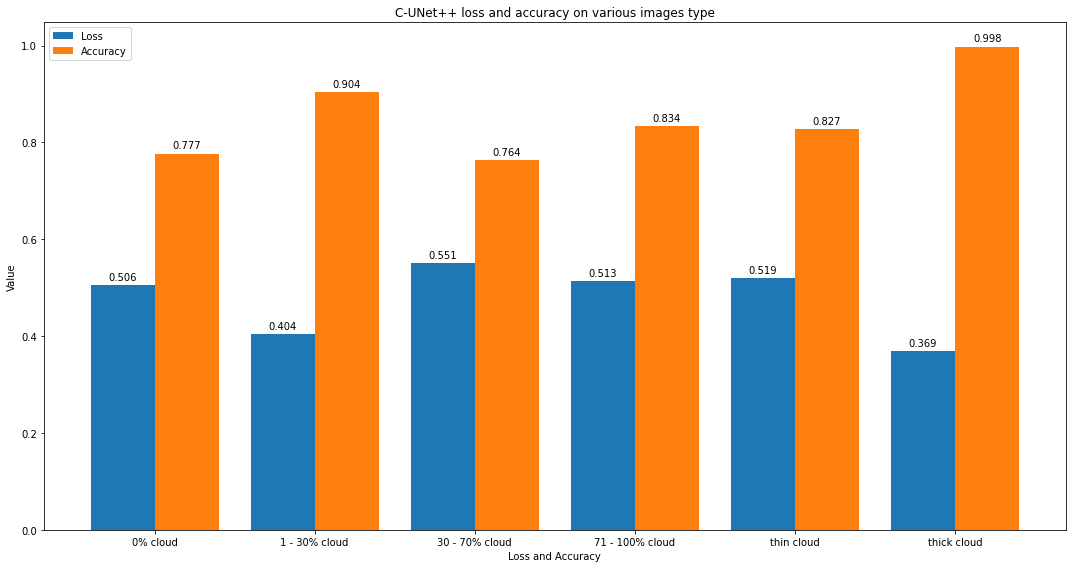

In [22]:
# data to plot
loss_list = (no_cloud_lost,
             less_cloud_lost,
             more_cloud_lost,
             full_cloud_lost,
             thin_cloud_lost,
             thick_cloud_lost)
acc_list = (no_cloud_acc,
            less_cloud_acc,
            more_cloud_acc,
            full_cloud_acc,
            thin_cloud_acc,
            thick_cloud_acc)
name_list = ("0% cloud", 
             "1 - 30% cloud", 
             "30 - 70% cloud",
             "71 - 100% cloud",
             "thin cloud",
             "thick cloud")

n_groups = len(name_list)

# create plot
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15, 8)
index = np.arange(n_groups)
bar_width = 0.4

rects1 = plt.bar(index + bar_width*0.5, loss_list, bar_width, label='Loss')

rects2 = plt.bar(index + bar_width*1.5, acc_list, bar_width, label='Accuracy')

plt.xlabel("Loss and Accuracy")
plt.ylabel("Value")
plt.title('C-UNet++ loss and accuracy on various images type')
plt.xticks(index + bar_width, name_list)
plt.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.savefig(r"C:\Users\hdmqu\Documents\GitHub\Cloud_Detection\Loss - accuracy bar.png", bbox_inches='tight')
plt.show()